In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Neural Network Code

CIS 481/581 Computational Learning

Instructor: Luis E Ortiz

In [136]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import warnings

from collections import defaultdict

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import ParameterGrid, KFold, train_test_split

from numpy.random import default_rng

In [137]:
rng = default_rng()

def random_uniform(n,m,R=[-1.0,1.0]):
  a, b = R[0], R[1]
  return (b - a) * rng.random((n,m)) + a

def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x))

def deriv_sigmoid(x):
  return sigmoid(x) * (1.0 - sigmoid(x))

def squared_error(y_true,y_pred):
  return 0.5 * (y_true - y_pred) ** 2

def deriv_squared_error(y_true,y_pred):
  return y_pred - y_true

def indicator(p):
  return p.astype(int)

def error_rate(y_true, y_pred):
  return 1.0 - np.mean(indicator(y_true == y_pred))

def identity(x):
  return x

def deriv_identity(x):
  return np.ones(x.shape)

In [138]:
def make_nunits(n,K,L,N):
  nunits = [n]
  for l in range(L):
    nunits.append(N)
  nunits.append(K)
  return nunits

def time_nnet(nunits):
  t = 0
  for l in range(len(nunits)-1):
    t += (nunits[l] + 1) * nunits[l+1]
  return t

In [139]:
MAX_ITERS = 50
MAX_NHIDU = 2**9
MAX_NHIDL = 2**2
MAX_M = 2000

n= 1024
K = 10

MAX_NUNITS = make_nunits(n,K,MAX_NHIDL,MAX_NHIDU)
MAX_NNET_TIME = time_nnet(MAX_NUNITS)

MAX_TIME = MAX_M * MAX_NNET_TIME * MAX_ITERS


In [140]:
class NNetBaseFunction:
    def __init__(self, f=None,df=None):
      self.f = f
      self.df = df

    def deepcopy(self):
      return NNetBaseFunction(f=self.f, df=self.df)

In [141]:
class NNetActivation(NNetBaseFunction):
    def __init__(self, f=sigmoid,df=deriv_sigmoid):
      super().__init__(f=f,df=df)

    def deepcopy(self):
      return NNetActivation(f=self.f, df=self.df)

In [142]:
class NNetLoss(NNetBaseFunction):
  def __init__(self, f=squared_error,df=deriv_squared_error):
    super().__init__(f=f,df=df)

  def deepcopy(self):
    return NNetLoss(f=self.f, df=self.df)

In [143]:
class NNetMetric(NNetBaseFunction):
  def __init__(self, f=error_rate):
    super().__init__(f=f,df=None)

  def deepcopy(self):
    return NNetMetric(f=self.f)

In [144]:
class NNetLayer:
  def __init__(self,n_in=1,n_out=1,W=None,
               unit=NNetActivation(), initializer=random_uniform):
    self.n_in = n_in
    self.n_out = n_out
    if initializer is None:
      initializer =  lambda n, m : np.zeros((n,m))
    self.initializer = initializer
    if W is None:
      W = self.initializer(n_out,n_in+1)
    else:
      self.n_in, self.n_out = W.shape[1]-1, W.shape[0]
    self.W = W
    self.unit = unit

  def ds(self, x):
    return self.unit.df(x)

  def deepcopy(self):
    return NNetLayer(n_in=self.n_in,n_out=self.n_out,W=self.W.copy(),
                     unit=self.unit)

  def copy_layer(self, layer):
    self.W[:] = layer.W[:]
    return self

  # assumes x[0,:] = +1
  def aggregation_with_dummy_input(self, x):
    return np.matmul(self.W,x)

  def aggregation(self, x):
    if x.shape[0] == self.W.shape[1]:
      x_tmp = x
    else:
      x_tmp = np.ones(self.W.shape[1],x.shape[1])
      x_tmp[1:,:] = x
    return self.aggregation_with_dummy_input(x_tmp)

  def activation(self, x):
    return self.unit.f(self.aggregation(x))

  def set_x(self, x):
    return x

  def set_y(self, y):
    return y

  def get_y(self):
    return None


In [145]:
class NNetIdentityLayer (NNetLayer):
  def __init__(self,n_in=1,n_out=1,W=None):
    super().__init__(n_in=n_in,n_out=n_out,W=W,
                     unit=NNetActivation(identity,deriv_identity))

In [146]:
class NNetLayerProp(NNetLayer):
  def __init__(self,n_in=1,n_out=1,W=None,
               unit=NNetActivation(sigmoid,deriv_sigmoid),m=1):
    super().__init__(n_in=n_in,n_out=n_out,W=W,unit=unit)
    # self.y = np.ones((n_out+1,m))
    # self.y[1:,:] = 0
    # self.delta = np.zeros((n_out+1,m))
    self.x = None
    self.y = None
    self.delta = None

  def deepcopy(self):
    copy = super().deepcopy()
    # Input is not "stored" by layer
    copy.x = self.x
    copy.y = None if self.y is None else self.y.copy()
    copy.delta = None if self.delta is None else self.delta.copy()
    return copy

  def set_x(self, x):
    self.x = x
    return x

  def set_y(self, y):
    self.y = y
    return y

  def set_delta(self, delta):
    self.delta = delta
    return delta

  def get_x(self):
    return self.x

  def get_y(self):
    return self.y

  def get_delta(self):
    return self.delta

  def dW(self):
    return np.matmul(self.delta,self.x.T)

In [147]:
class NNetInputLayerProp(NNetLayerProp):
  def __init__(self,n_in=1,n_out=1,W=None,m=1):
    super().__init__(n_in=n_in,n_out=n_out,W=W,unit=NNetActivation(identity,deriv_identity))
    self.y = None

  def deepcopy(self):
    obj = super().deepcopy()
    obj.y = None if self.y is None else self.y.deepcopy()
    return obj


In [148]:
class NNetOptimizer:
  def __init__(self,loss=NNetLoss(),metric=NNetMetric()):
    self.loss = loss
    self.metric = metric
    self.best_nnet = None
    self.last_nnet = None
    self.train_err = []
    self.test_err = []
    return self

  def deepcopy(self):
    opt = NNetOptimizer(loss=self.loss.deepcopy(),metric=self.metric.deepcopy())
    opt.best_nnet = None if self.best_nnet is None else self.best_nnet.deepcopy()
    opt.last_nnet = None if self.best_nnet is None else self.last_nnet.deepcopy()
    opt.train_err = self.train_err.deepcopy()
    opt.test_err = self.test_err.deepcopy()
    return opt

  def run(self,nnet,X,y):
    return self.best_nnet

In [149]:
class NNet:
  def __init__(self, nunits=[0,0], unit=NNetActivation(sigmoid,deriv_sigmoid),
               output_unit=None, Layer=NNetLayerProp, InputLayer=NNetInputLayerProp):
    self.nunits = nunits
    self.unit = unit
    self.output_unit = unit if output_unit is None else output_unit
    self.nlayers = len(nunits)
    self.layer = []
    self.layer.append(InputLayer(n_in=1,n_out=nunits[0]))

    for l in range(1,self.nlayers-1):
      self.layer.append(Layer(n_in=nunits[l-1],n_out=nunits[l],unit=unit))

    self.layer.append(Layer(n_in=nunits[-2],n_out=nunits[-1],
                                unit=self.output_unit))

  def copy(self, nnet_copy=None, Layer=NNetLayerProp, InputLayer=NNetInputLayerProp):
    if nnet_copy is None:
      nnet_copy = NNet(nunits=self.nunits,unit=self.unit,output_unit=self.output_unit, Layer=Layer, InputLayer=InputLayer)
    nnet_copy.copy_layers(self)
    return nnet_copy

  def deepcopy(self, nnet_copy=None):
    nnet_copy = self.copy(nnet_copy=nnet_copy)

    nnet_copy.nunits = copy.deepcopy(self.nunits)
    nnet_copy.unit = self.unit.deepcopy()
    nnet_copy.output_unit = self.output_unit.deepcopy()

    for l in range(1,self.nlayers):
      nnet_copy.layer[l] = self.layer[l].deepcopy()

    return nnet_copy

  def copy_layers(self, nnet_copy_from):
    for l in range(self.nlayers):
      self.layer[l].copy_layer(nnet_copy_from.layer[l])
    return self

  def error(self, X, y, loss=squared_error, metric=None):
    output = self.forwardprop(X.T)
    err = np.mean(loss(y.T, output))
    err_rate = 1.0 if metric is None else metric(y.T,output)
    return err, err_rate

  def forwardprop(self,X):
    m = X.shape[1]
    out_vals = np.ones((X.shape[0]+1,m))
    out_vals[1:,:] = X
    self.layer[0].set_y(out_vals)

    for l in range(1,self.nlayers):
      self.layer[l].set_x(self.layer[l-1].get_y())
      del out_vals
      out_vals = np.ones((self.nunits[l]+1,m))
      out_vals[1:,:] = self.layer[l].activation(self.layer[l].get_x())
      self.layer[l].set_y(out_vals)

    return out_vals[1:,:]

  def backprop(self,X,y,dE='deriv_squared_error'):
    net_output = self.forwardprop(X)

    layer = self.layer[self.nlayers-1]
    layer.set_delta(layer.ds(net_output) * dE(y,net_output))

    for l in range(self.nlayers-1,1,-1):
      next_layer = self.layer[l]
      layer = self.layer[l-1]
      x = layer.get_y()[1:,:]
      d = next_layer.delta
      layer.set_delta(layer.ds(x) * np.matmul(next_layer.W[:,1:].T,d))

    dW = []
    for l in range(self.nlayers):
      dW.append(None)

    for l in range(self.nlayers-1,0,-1):
      dW[l] = self.layer[l].dW()

    return dW

  def fit(self, X, y, X_test=None, y_test=None, optimizer=None, verbose=0):
    if optimizer is None:
      optimizer = NNetGDOptimizer(loss=NNetLoss())

    best_nnet = optimizer.run(self,X,y,X_test,y_test,verbose)

    self.copy_layers(best_nnet)

    return self


In [150]:
class NNetGDOptimizer(NNetOptimizer):
  def __init__(self,loss=NNetLoss(),max_iters=100, learn_rate=1, reg_param=0,
               change_thresh=1e-4, change_err_thresh=1e-6,metric=NNetMetric()):
    super().__init__(loss=loss,metric=metric)
    self.max_iters = max_iters
    self.learn_rate = learn_rate
    self.reg_param = reg_param
    self.change_thresh = change_thresh
    self.change_err_thresh = change_err_thresh

  def deepcopy(self):
    opt = super().deepcopy()
    return NNetGDOptimizer(loss=opt.loss, max_iters=self.max_iters, learn_rate=self.learn_rate, reg_param=self.reg_param,
               change_thresh=self.change_thresh, change_err_thresh=self.change_err_thresh,metric=opt.metric)

  def run(self, nnet, X, y, X_test=None, y_test=None, verbose=0):

    m = X.shape[0]
    eval_test = X_test is not None and y_test is not None
    new_nnet = NNet(nunits=nnet.nunits,unit=nnet.unit,output_unit=nnet.output_unit,Layer=NNetLayerProp,InputLayer=NNetInputLayerProp)
    new_nnet.copy_layers(nnet)

    t = 0
    max_change = math.inf
    min_change_err = math.inf

    train_err = []
    test_err = []

    err, err_rate = new_nnet.error(X, y, loss=self.loss.f, metric=self.metric.f)
    if verbose > 0:
      print((err,err_rate))
    min_err, min_err_rate = err, err_rate

    if eval_test:
      cv_err,cv_err_rate = new_nnet.error(X_test, y_test, loss=self.loss.f, metric=self.metric.f)

    best_nnet = nnet.deepcopy()
    best_nnet.copy_layers(new_nnet)

    while min_change_err > self.change_err_thresh and max_change > self.change_thresh and t < self.max_iters:
      if verbose > 0:
        print(t)
        print("Backprop...")

      dW = new_nnet.backprop(X.T, y.T,dE=self.loss.df)

      if verbose > 0:
        print("done.")
        print("Update...")

      max_change = 0

      for l in range(new_nnet.nlayers-1,0,-1):
        delta_W = self.learn_rate * (dW[l] / m + self.reg_param * new_nnet.layer[l].W)
        new_nnet.layer[l].W[:] = new_nnet.layer[l].W[:] - delta_W[:]
        max_change = max(max_change, np.max(np.absolute(delta_W)))

      del dW[:]

      if verbose > 0:
        print("done.")

      last_err = err
      err,err_rate = new_nnet.error(X, y, loss=self.loss.f, metric=self.metric.f)
      if verbose > 0:
        print((err,err_rate))
      min_change_err = np.absolute(err-last_err)


      if verbose > 0:
        print("max_change")
        print(max_change)

      if eval_test:
        cv_err,cv_err_rate = new_nnet.error(X_test, y_test, loss=self.loss.f, metric=self.metric.f)

      if verbose > 0:
        if eval_test:
          print("(test_err,test_err_rate)")
          print((cv_err,cv_err_rate))

      if err < min_err:
        min_err = err
        min_err_rate = err_rate
        best_nnet.copy_layers(new_nnet)

      t += 1

      train_err.append([err, err_rate])
      if eval_test:
        test_err.append([cv_err, cv_err_rate])

    if verbose > 0:
      if eval_test:
        print("(best_train_err,best_train_err_rate)")
        print((min_err,min_err_rate))

    self.train_err = train_err
    self.test_err = test_err

    return best_nnet

In [151]:
def perception_model(learning_rate):
  nunits=[n,K]
  nnet_time = time_nnet(nunits)
  R = min(1000, math.ceil(MAX_TIME / (m * nnet_time)))
  nnet = NNet(nunits=nunits)
  optimizer = NNetGDOptimizer(learn_rate=learning_rate, max_iters=R)
  return nnet, optimizer

In [152]:
def dnn_model(depth, learning_rate=1):
  nunits = [n] + [64] * depth + [K]
  nnet = NNet(nunits=nunits)
  nnet_time = time_nnet(nunits)
  R = min(1000, math.ceil(MAX_TIME / (m * nnet_time)))
  optimizer = NNetGDOptimizer(learn_rate=learning_rate, max_iters=R)
  return nnet, optimizer

In [153]:
def dnn_two_layer_model(learning_rate):
  nunits = [n, 256, 64, K]
  nnet = NNet(nunits=nunits)
  nnet_time = time_nnet(nunits)
  R = min(1000, math.ceil(MAX_TIME / (m * nnet_time)))
  optimizer = NNetGDOptimizer(learn_rate=learning_rate, max_iters=R)
  return nnet, optimizer

In [154]:
def train_evaluate_model(nnet, optimizer, X, y, X_test, y_test, model_name):
  best_nnet = nnet.fit(X, y, X_test, y_test, optimizer=optimizer, verbose=1)
  train_err, test_err = np.array(optimizer.train_err), np.array(optimizer.test_err)

  # Plot Proxy Error
  plt.figure(figsize=(8, 4))
  plt.plot(train_err[:, 0], label="Training Proxy Error", color='red')
  plt.plot(test_err[:, 0], label="Testing Proxy Error", color='purple')
  plt.title(f"Proxy Error (Gradient Descent Fitting) for {model_name}")
  plt.xlabel("Iterations")
  plt.ylabel("Proxy Error (MSE)")
  plt.ylim(0.00, 0.10)
  plt.legend()
  plt.show()

  # Plot Misclassification Error
  plt.figure(figsize=(8, 4))
  plt.plot(train_err[:, 1], label="Training Misclassification Error", color='blue')
  plt.plot(test_err[:, 1], label="Testing Misclassification Error", color='orange')
  plt.title(f"Misclassification Error for {model_name}")
  plt.xlabel("Iterations")
  plt.ylabel("Misclassification Error")
  plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8])
  plt.legend()
  plt.show()

  print(f"Final Test Error for {model_name}: {test_err[-1, 1]}")

In [155]:
if __name__ == '__main__':
  D = np.loadtxt('/content/drive/My Drive/CIS 481 Project 2/optdigits_train.dat')
  D_test = np.loadtxt('/content/drive/My Drive/CIS 481 Project 2/optdigits_test.dat')
  D_trial = np.loadtxt('/content/drive/My Drive/CIS 481 Project 2/optdigits_trial.dat')

In [156]:
  m, n = D.shape[0], D.shape[1]-1

  X = D[:,:-1].reshape(m,n)
  y = D[:,-1].reshape(m,1)

  out_enc = LabelBinarizer()
  y_ohe = out_enc.fit_transform(y)

  K = y_ohe.shape[1]

  m_test = D_test.shape[0]

  X_test = D_test[:,:-1].reshape(m_test,n)
  y_test = D_test[:,-1].reshape(m_test,1)

  y_test_ohe = out_enc.transform(y_test)

  m_trial = D_trial.shape[0]

  X_trial = D_trial[:,:-1].reshape(m_trial,n)
  y_trial = D_trial[:,-1].reshape(m_trial,1)

  y_trial_ohe = out_enc.transform(y_trial)

[4.]


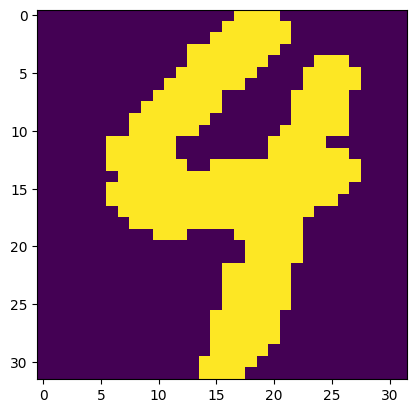

In [157]:
  plt.imshow(X[53,:].reshape(32,32))
  print(y[53])

[2.]


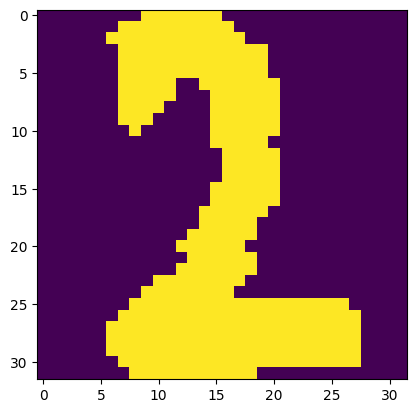

In [158]:
  plt.imshow(X_trial[1,:].reshape(32,32))
  print(y_trial[1])

In [159]:
  def nnet_error_rate(y_true, y_pred):
    y_pred_label = np.argmax(y_pred,axis=0).reshape(-1,1)
    y_true_label = out_enc.inverse_transform(y_true.T).reshape(-1,1)
    return error_rate(y_true_label, y_pred_label)

In [160]:
  nnet_metric = NNetMetric(f=nnet_error_rate)

In [161]:
  print(n)
  print(K)
  print(m)
  print(m_test)

  nnet = NNet(nunits=[n, 512, 512, 512, 512, K])

  opt = NNetGDOptimizer(metric=nnet_metric, max_iters=50, learn_rate=1)

  # best_nnet = nnet.fit(X[:1000,:],y_ohe[:1000,:],X_test,y_test_ohe,optimizer=opt,verbose=1)
  best_nnet = nnet.fit(X,y_ohe,X_test,y_test_ohe,optimizer=opt,verbose=1)

1024
10
1934
946
(np.float64(0.27399442642698846), np.float64(0.9198552223371251))
0
Backprop...
done.
Update...
done.


<ipython-input-137-8b906e22452d>:8: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


(np.float64(0.08833703011723619), np.float64(0.9038262668045501))
max_change
4.128294659721191
(test_err,test_err_rate)
(np.float64(0.08594397919103436), np.float64(0.879492600422833))
1
Backprop...
done.
Update...
done.
(np.float64(0.10874615989341181), np.float64(0.9069286452947259))
max_change
5.142241270449477
(test_err,test_err_rate)
(np.float64(0.10873542138907842), np.float64(0.9038054968287527))
2
Backprop...
done.
Update...
done.
(np.float64(0.089997343179338), np.float64(0.9022750775594622))
max_change
10.941136345326449
(test_err,test_err_rate)
(np.float64(0.09057297425025053), np.float64(0.9080338266384778))
3
Backprop...
done.
Update...
done.
(np.float64(0.08923339867938457), np.float64(0.8976215098241985))
max_change
15.745318552809433
(test_err,test_err_rate)
(np.float64(0.08923991579302484), np.float64(0.897463002114165))
4
Backprop...
done.
Update...
done.
(np.float64(0.10136553766794276), np.float64(0.8971044467425026))
max_change
9.905872990515354
(test_err,test_err_

0.445031712473573


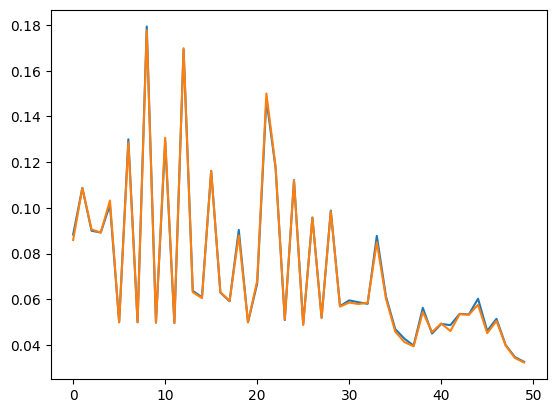

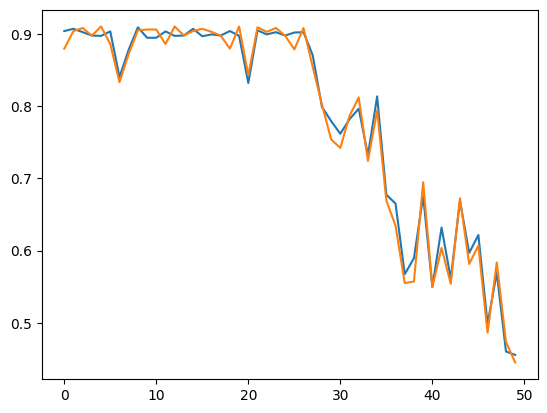

In [162]:
  train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)

  print(test_err[-1,1])

  plt.plot(train_err[:,0])
  plt.plot(test_err[:,0])
  plt.show()

  plt.plot(train_err[:,1])
  plt.plot(test_err[:,1])
  plt.show()

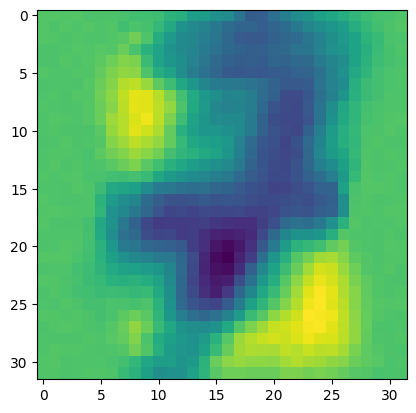

In [163]:
  plt.imshow(best_nnet.layer[1].W[0,1:].reshape(32,32))

In [164]:
  n_hidu = 128 # 512
  n_hidl = 2

  nunits = make_nunits(n,K,n_hidl,n_hidu)
  nnet_time = time_nnet(nunits)

  R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))

  print(R)

458


In [165]:
n_hidu = 128 # 512
n_hidl = 2

nunits = [1024, 512, 256, 128, 64, 10]
nnet_time = time_nnet(nunits)

R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))

print(R)

98


In [166]:
  # opt = NNetGDOptimizer(metric=nnet_metric, max_iters=400, learn_rate=0.5**8)
  opt = NNetGDOptimizer(metric=nnet_metric, max_iters=R, learn_rate=2**-1, change_err_thresh=0, change_thresh=0)

  # nnet = NNet(nunits=[1024, 512, 512, 10],unit=NNetActivation(identity,deriv_identity),output_unit=NNetActivation(sigmoid,deriv_sigmoid))
  nnet = NNet(nunits=nunits)

  best_nnet = nnet.fit(X,y_ohe,X_test,y_test_ohe,optimizer=opt,verbose=1)
  # est_nnet = nnet.fit(X,y_ohe,optimizer=opt,verbose=1)

(np.float64(0.1980003861911233), np.float64(0.9043433298862461))
0
Backprop...
done.
Update...
done.
(np.float64(0.05459977899965842), np.float64(0.8955532574974147))
max_change
0.23876035419626876
(test_err,test_err_rate)
(np.float64(0.05467269991895036), np.float64(0.9006342494714588))
1
Backprop...
done.
Update...
done.
(np.float64(0.047502899776347925), np.float64(0.9100310237849017))
max_change
0.06385934657615536
(test_err,test_err_rate)
(np.float64(0.0471184560786963), np.float64(0.897463002114165))
2
Backprop...
done.
Update...
done.
(np.float64(0.04533186947585679), np.float64(0.8376421923474664))
max_change
0.03882392064309424
(test_err,test_err_rate)
(np.float64(0.045227637765222796), np.float64(0.8192389006342495))
3
Backprop...
done.
Update...
done.
(np.float64(0.043495195919555404), np.float64(0.7554291623578077))
max_change
0.02694032721996085
(test_err,test_err_rate)
(np.float64(0.04358547972769113), np.float64(0.7621564482029598))
4
Backprop...
done.
Update...
done.
(n

0.10147991543340384


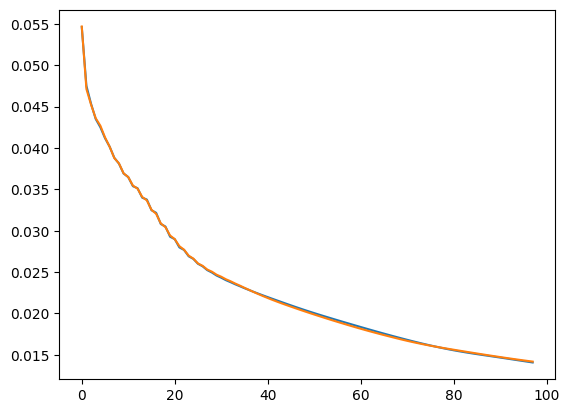

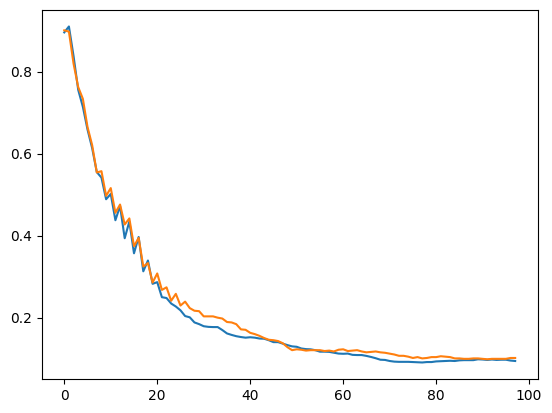

In [167]:
  train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)

  print(test_err[-1,1])

  plt.plot(train_err[:,0])
  plt.plot(test_err[:,0])
  plt.show()

  plt.plot(train_err[:,1])
  plt.plot(test_err[:,1])
  plt.show()

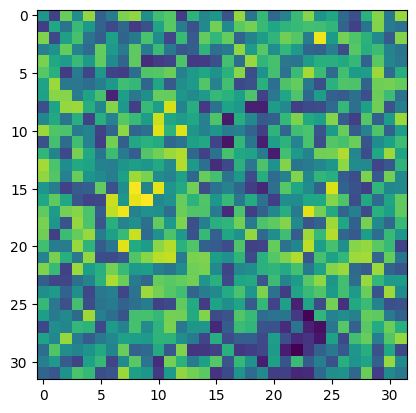

In [168]:
  plt.imshow(best_nnet.layer[1].W[10,1:].reshape(32,32))

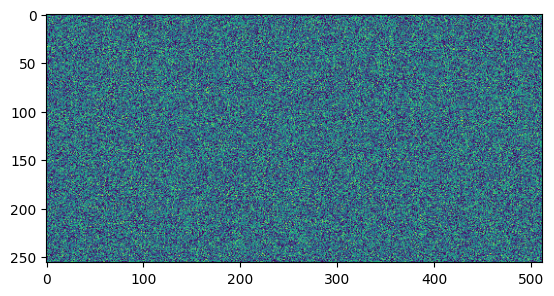

In [169]:
  plt.imshow(np.absolute(best_nnet.layer[2].W[:,1:]))

Streaming output truncated to the last 5000 lines.
done.
Update...
done.
(np.float64(0.0038887277520106003), np.float64(1.0))
max_change
0.0006783770939580474
(test_err,test_err_rate)
(np.float64(0.008024167657794304), np.float64(1.0))
501
Backprop...
done.
Update...
done.
(np.float64(0.0038826189050610188), np.float64(1.0))
max_change
0.0006774640111516998
(test_err,test_err_rate)
(np.float64(0.008020799957512856), np.float64(1.0))
502
Backprop...
done.
Update...
done.
(np.float64(0.00387652979149726), np.float64(1.0))
max_change
0.0006765537780184698
(test_err,test_err_rate)
(np.float64(0.008017445931979337), np.float64(1.0))
503
Backprop...
done.
Update...
done.
(np.float64(0.0038704603112672442), np.float64(1.0))
max_change
0.0006756463836607375
(test_err,test_err_rate)
(np.float64(0.008014105496728204), np.float64(1.0))
504
Backprop...
done.
Update...
done.
(np.float64(0.003864410364704255), np.float64(1.0))
max_change
0.0006747418172237669
(test_err,test_err_rate)
(np.float64(0.0

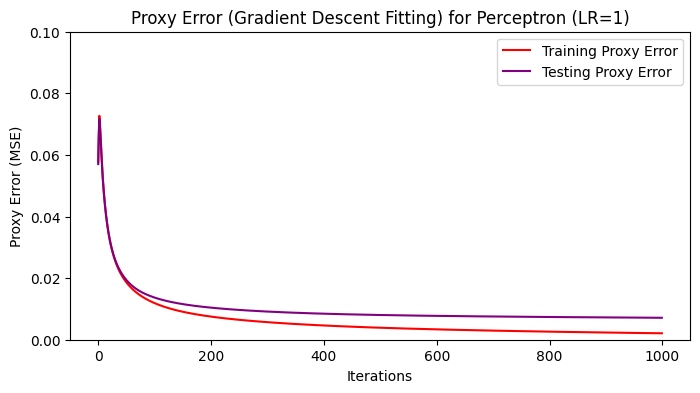

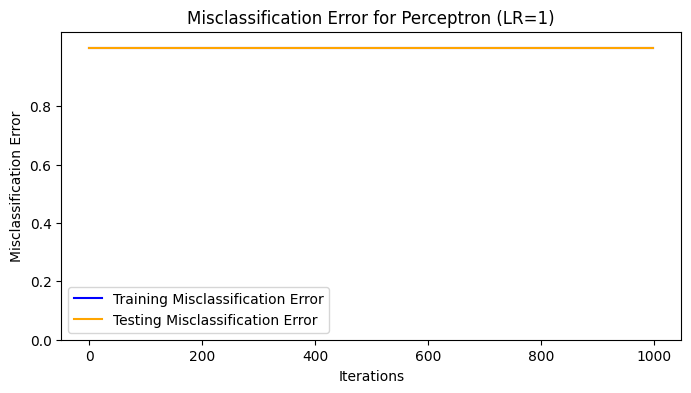

Final Test Error for Perceptron (LR=1): 1.0
(np.float64(0.2736213340753217), np.float64(1.0))
0
Backprop...
done.
Update...
done.
(np.float64(0.053105405824215315), np.float64(1.0))
max_change
0.6352007534298658
(test_err,test_err_rate)
(np.float64(0.05349717052238294), np.float64(1.0))
1
Backprop...
done.
Update...
done.
(np.float64(0.07753388140575342), np.float64(1.0))
max_change
0.10548086866597725
(test_err,test_err_rate)
(np.float64(0.08008435816502574), np.float64(1.0))
2
Backprop...
done.
Update...
done.
(np.float64(0.05356425571275855), np.float64(1.0))
max_change
0.49003777487575845
(test_err,test_err_rate)
(np.float64(0.05454820090494931), np.float64(1.0))
3
Backprop...
done.
Update...
done.
(np.float64(0.05186011910807704), np.float64(1.0))
max_change
0.15509711340225948
(test_err,test_err_rate)
(np.float64(0.05067342852681493), np.float64(1.0))
4
Backprop...
done.
Update...
done.
(np.float64(0.034805316235501815), np.float64(1.0))
max_change
0.1605728565763686
(test_err,te

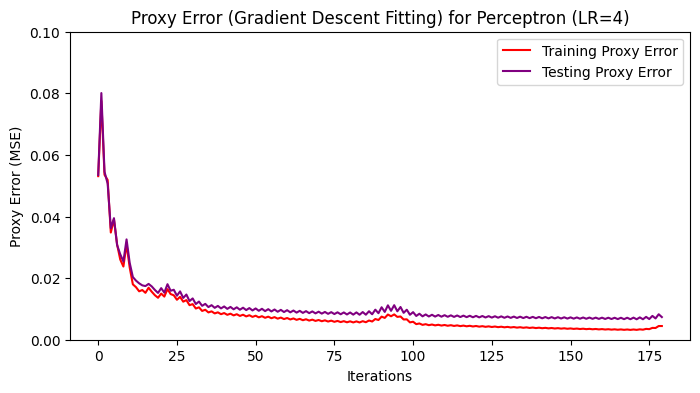

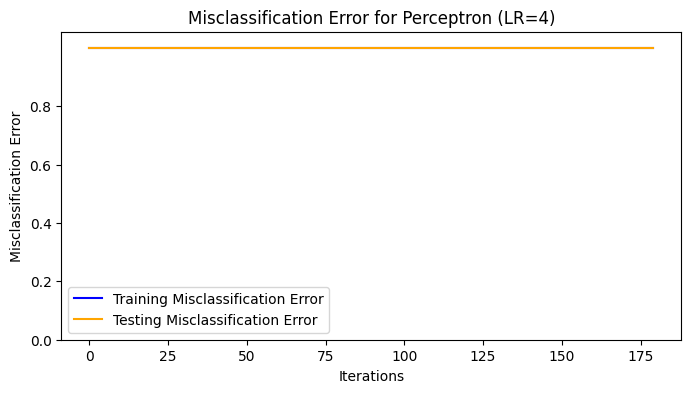

Final Test Error for Perceptron (LR=4): 1.0
(np.float64(0.19684345451726598), np.float64(1.0))
0
Backprop...
done.
Update...
done.
(np.float64(0.09012265625974891), np.float64(0.9903309203722854))
max_change
1.9835005321600911
(test_err,test_err_rate)
(np.float64(0.09071053891301813), np.float64(0.9908033826638478))
1
Backprop...
done.
Update...
done.
(np.float64(0.07542067282469476), np.float64(0.9922440537745605))
max_change
2.8355473184277318
(test_err,test_err_rate)
(np.float64(0.07555258589367628), np.float64(0.991754756871036))
2
Backprop...
done.
Update...
done.
(np.float64(0.08560854362476954), np.float64(0.984488107549121))
max_change
2.0023783929987204
(test_err,test_err_rate)
(np.float64(0.08217424272116838), np.float64(0.9815010570824524))
3
Backprop...
done.
Update...
done.
(np.float64(0.0774590113817022), np.float64(0.9830403309203722))
max_change
2.670215233686679
(test_err,test_err_rate)
(np.float64(0.07882328076507819), np.float64(0.9830866807610994))
4
Backprop...
don

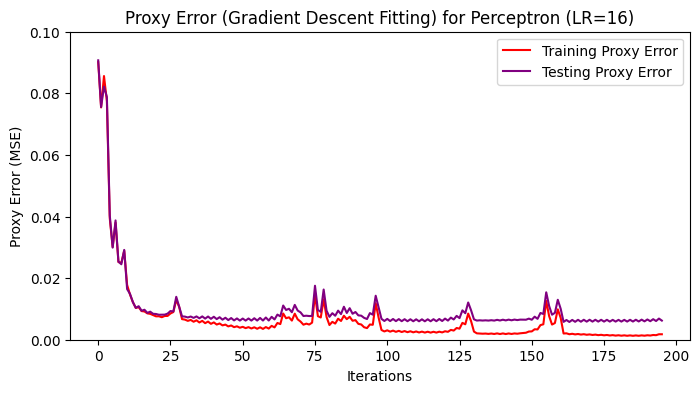

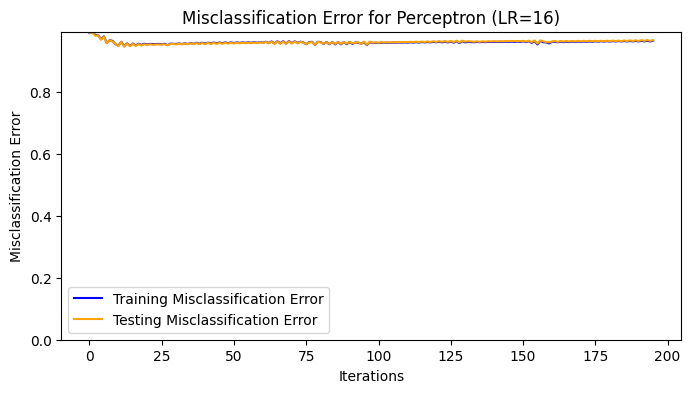

Final Test Error for Perceptron (LR=16): 0.9677589852008457
(np.float64(0.2365477280129257), np.float64(1.0))
0
Backprop...
done.
Update...
done.
(np.float64(0.04999947116340284), np.float64(0.46070320579110646))
max_change
11.22746015197884
(test_err,test_err_rate)
(np.float64(0.049999987387636696), np.float64(0.4614164904862579))
1
Backprop...
done.
Update...
done.
(np.float64(0.11966405466138033), np.float64(0.4961737331954499))
max_change
1.687693898655636
(test_err,test_err_rate)
(np.float64(0.11977858705173289), np.float64(0.5007399577167019))
2
Backprop...
done.
Update...
done.


<ipython-input-137-8b906e22452d>:8: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


(np.float64(0.09776544802572396), np.float64(0.4877456049638056))
max_change
11.242522540093901
(test_err,test_err_rate)
(np.float64(0.09640020714963908), np.float64(0.4859408033826639))
3
Backprop...
done.
Update...
done.
(np.float64(0.04570667059762779), np.float64(0.46742502585315404))
max_change
10.910439931038852
(test_err,test_err_rate)
(np.float64(0.044443499430367586), np.float64(0.4698731501057083))
4
Backprop...
done.
Update...
done.
(np.float64(0.04375142172888312), np.float64(0.6015511892450879))
max_change
1.687693898655636
(test_err,test_err_rate)
(np.float64(0.04246919785251765), np.float64(0.6027484143763213))
5
Backprop...
done.
Update...
done.
(np.float64(0.04131291884157189), np.float64(0.6814374353671148))
max_change
1.687693898655636
(test_err,test_err_rate)
(np.float64(0.04055923831197031), np.float64(0.6849894291754757))
6
Backprop...
done.
Update...
done.
(np.float64(0.033231267386904), np.float64(0.76923474663909))
max_change
2.187301984814415
(test_err,test_er

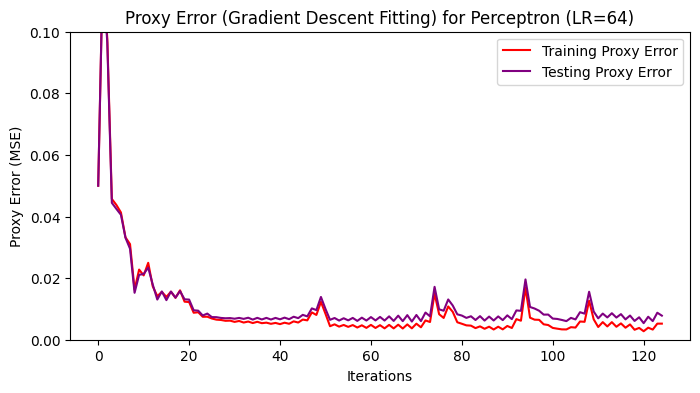

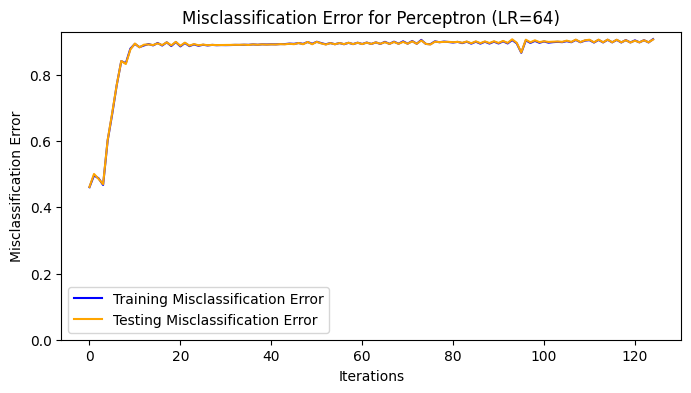

Final Test Error for Perceptron (LR=64): 0.9067653276955603
(np.float64(0.24204126901543785), np.float64(1.0))
0
Backprop...
done.
Update...
done.
(np.float64(0.04721770850569378), np.float64(0.18448810754912104))
max_change
44.1044754133455
(test_err,test_err_rate)
(np.float64(0.04829983664757453), np.float64(0.1858350951374207))
1
Backprop...
done.
Update...
done.
(np.float64(0.06954754271634095), np.float64(0.29705274043433294))
max_change
6.750775594622544
(test_err,test_err_rate)
(np.float64(0.07149133157989422), np.float64(0.30422832980972514))
2
Backprop...
done.
Update...
done.
(np.float64(0.08710765961950677), np.float64(0.24219234746639084))
max_change
17.904931679322978
(test_err,test_err_rate)
(np.float64(0.086204777889825), np.float64(0.24133192389006342))
3
Backprop...
done.
Update...
done.
(np.float64(0.06315282975079874), np.float64(0.2507238883143743))
max_change
45.64812652007001
(test_err,test_err_rate)
(np.float64(0.06105863386939664), np.float64(0.24513742071881606

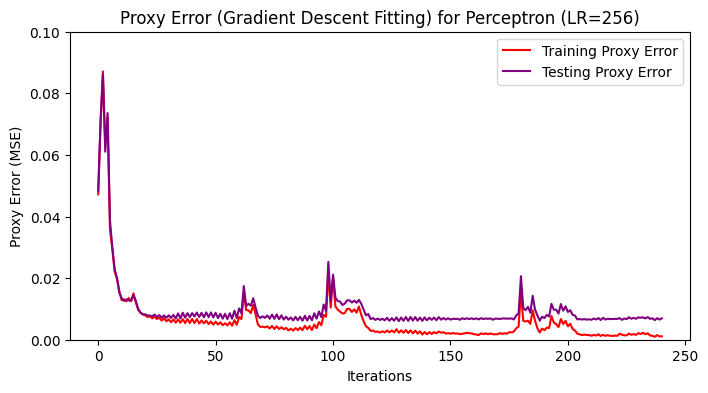

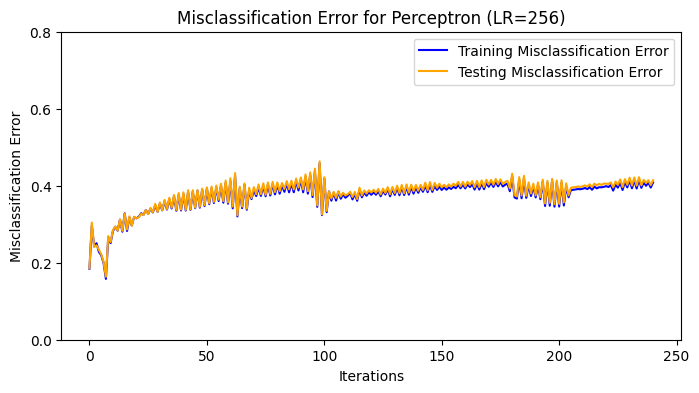

Final Test Error for Perceptron (LR=256): 0.4141649048625793


In [170]:
learning_rates = [1,4,16,64,256]
for lr in learning_rates:
  nnet, optimizer = perception_model(learning_rate=lr)
  train_evaluate_model(nnet, optimizer, X, y_ohe, X_test, y_test_ohe, f"Perceptron (LR={lr})")

In [ ]:
depths = [1,2,3,4]
for depth in depths:
  nnet, optimizer=dnn_model(depth=depth)
  train_evaluate_model(nnet, optimizer, X, y_ohe, X_test, y_test_ohe, f"DNN (Depth={depth})")

Streaming output truncated to the last 5000 lines.
(np.float64(0.01276999182938455), np.float64(1.0))
max_change
0.0027283846875376595
(test_err,test_err_rate)
(np.float64(0.012874158517759993), np.float64(1.0))
105
Backprop...
done.
Update...
done.
(np.float64(0.012709597582479592), np.float64(1.0))
max_change
0.0027204768978160818
(test_err,test_err_rate)
(np.float64(0.01281546833865012), np.float64(1.0))
106
Backprop...
done.
Update...
done.
(np.float64(0.012650131867414904), np.float64(1.0))
max_change
0.0027124367312027172
(test_err,test_err_rate)
(np.float64(0.012757839991579891), np.float64(1.0))
107
Backprop...
done.
Update...
done.
(np.float64(0.012591579607480812), np.float64(1.0))
max_change
0.002704264598003268
(test_err,test_err_rate)
(np.float64(0.012701249136415226), np.float64(1.0))
108
Backprop...
done.
Update...
done.
(np.float64(0.012533926435482425), np.float64(1.0))
max_change
0.002695961345586937
(test_err,test_err_rate)
(np.float64(0.01264567187002997), np.float6

In [ ]:
learning_rates=[0.125, 0.25, 0.5, 1, 4]
for lr in learning_rates:
  nnet, optimizer = dnn_two_layer_model(learning_rate=lr)
  train_evaluate_model(nnet, optimizer, X, y_ohe, X_test, y_test_ohe, f"Two-Layer DNN (LR={lr})")